# 01 - AR Modelling

Autoregressive (AR) modelling is a common approach used to model time series data. It assumes that previous values in the time series are able to predict the future values. One of the simplest variation of its formula is:

$$ y_t = c + \phi_1 y_{t-1} + \epsilon_t $$

One of the parameters for AR modelling is order **p**, where it indicates the number of lagged terms that we will include in our modelling. **p** parameter is usually determined through eyeballing PACF visuals and also statistical methods like Augmented Dickey-Fuller test. We will be going through the entire process of AR modelling from the start using a toy dataset, which is the infamous airline passengers dataset.

As with any other statistical techniques, we require to fulfill some of the assumptions of  the technique before we can start the modelling process. Some of the important assumptions are:

* Autocorrelation between observations and its lagged term/s.
* Stationary time series 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis 

In [11]:
airpassengers = pd.read_csv('../datasets/decomposition/AirPassengers.csv', 
                            index_col=0, parse_dates=True)
airpassengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0.5, 1.0, '# of airpassengers')

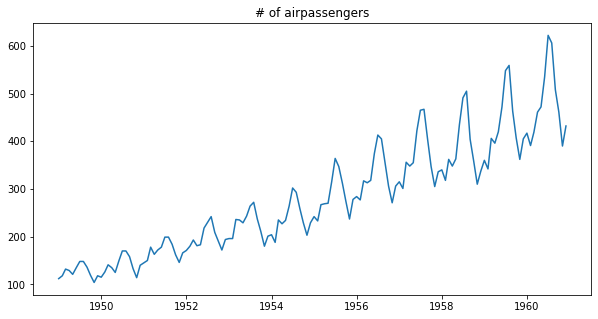

In [12]:
plt.plot(airpassengers)
plt.title('# of airpassengers')

The time series data appears to be non-stationary. Nonetheless, this is a very evident example and sometimes it might not be this obvious. So, we will just introduce some ways to confirm this.

## Checking for Stationarity

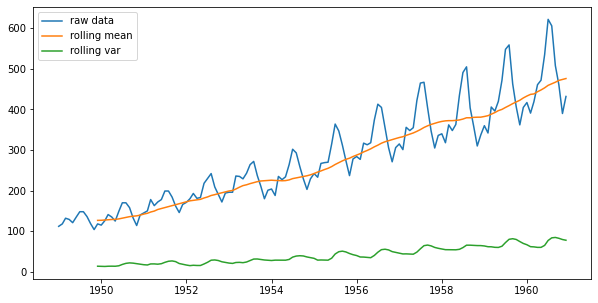

In [16]:
SMA = airpassengers.rolling(12).mean()

plt.plot(airpassengers, label = 'raw data')
plt.plot(airpassengers.rolling(window=12).mean(), label="rolling mean");
plt.plot(airpassengers.rolling(window=12).std(), label="rolling var");
plt.legend()
plt.show()

SMA shows that the trend component is trending upwards against time, hence the violation of stationarity for time series, which is the mean has to be constant throughout time. Also, the rolling variance appears to be fluctuating instead of being constant, another violation of stationarity.

Let's try to fix this.

There are many techniques (logarithm, exponential, de-trending, differencing) which can be used to transform non-stationary series into stationary.

Which technique to use depend on the pattern of our time series

Since we has a series with increment variance, logarithm transformation can be use to smooth out the variance.

In [17]:
airpassengers_log = np.log(airpassengers)

Text(0.5, 1.0, 'log transformation')

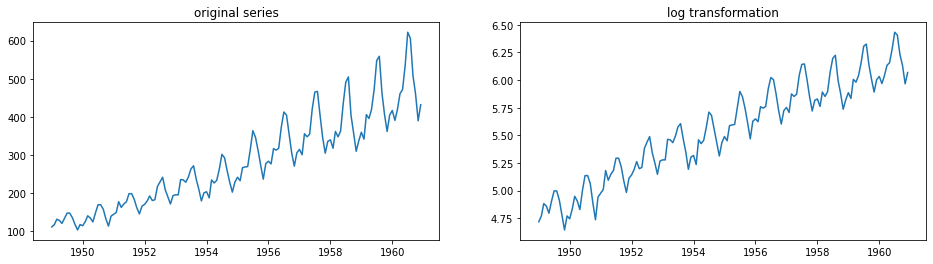

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers)
ax1.set_title('original series')

ax2.plot(airpassengers_log)
ax2.set_title('log transformation')

Log transformation appears to have stabilized the fluctuating variance of seasonality. Let us proceed with doing a differencing. Recall that differencing is the mathematical operation of subtrating the term against its lag-1 self in order to eliminate trend and seasonality. What is left is the residuals.

In [20]:
airpassengers_diff = airpassengers_log.diff()

Text(0.5, 1.0, 'differencing')

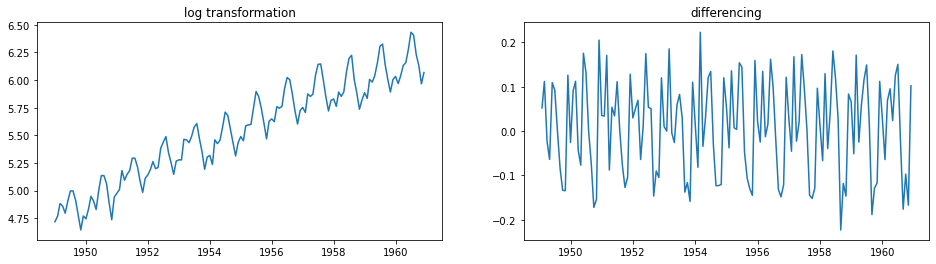

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_log)
ax1.set_title('log transformation')

ax2.plot(airpassengers_diff)
ax2.set_title('differencing')

The visual on the right indicates that the mean is constant now. Let's confirm it.

## Stationarity Check

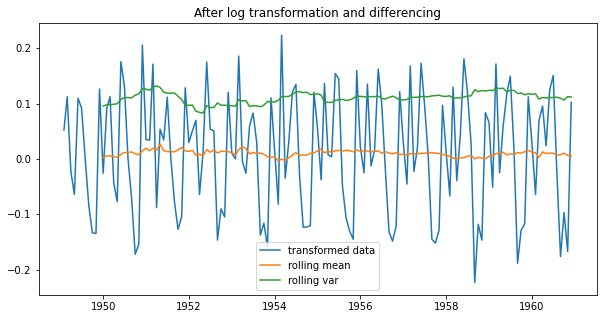

In [24]:
plt.plot(airpassengers_diff, label = 'transformed data')
plt.plot(airpassengers_diff.rolling(window=12).mean(), label="rolling mean");
plt.plot(airpassengers_diff.rolling(window=12).std(), label="rolling var");
plt.title("After log transformation and differencing")
plt.legend();

Looks good. However, it can never be too safe by using statistical technique to confirm it. Let's do a ADF.

### Augmented Dickey-Fuller Test (ADF)

ADF is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.

A time series is stationary if a single shift in time doesn’t change the time series statistical properties, in which case unit root does not exist.

The Null and Alternate hypothesis of the Augmented Dickey-Fuller test is defined as follows:

$H_0$:  There is the presence of a unit root.

$H_1$:  There is no unit root. In other words, Stationarity exists. 

In [25]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)

In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(airpassengers, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        1.564685
P-Value                   0.997748
# Lags Used              12.000000
# Observations Used     131.000000
Critical Value (1%)      -3.481282
Critical Value (5%)      -2.883868
Critical Value (10%)     -2.578677
dtype: float64


In [27]:
result = adfuller(airpassengers_diff[1:], maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.053032
P-Value                   0.030230
# Lags Used              12.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


Since the p-value for the time series before pre-processing is higher than 0.05, alternative hypothesis is rejected and the time series is non-stationary.

For the p-value for time series after processing is lower than 0.05, null hypothesis is rejected and the time series is stationary based on ADF test.

### P-order determination using Partial Autocorrelation Function (PACF)

In order to determine a suitable **p** parameter to perform AR modelling, we can use PACF to choose the suitable order for **p**. We also plotted a ACF graph to check whether the differenced time series still has autocorrelation between its lagged terms.

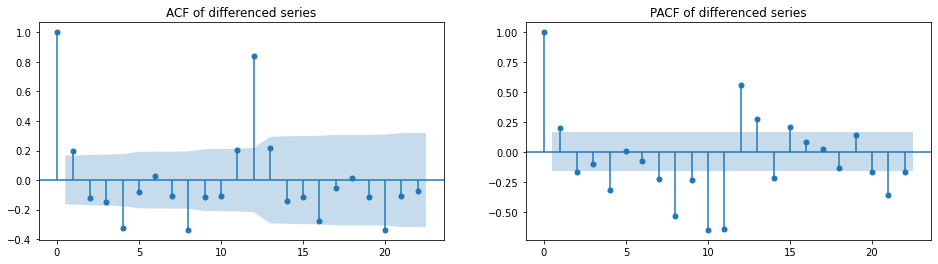

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

# 1st row is NAN due to there are no previous term to be differenced, check by uncommenting
# print(airpassengers.head())
plot_acf(airpassengers_diff[1:], ax1) 
ax1.set_title('ACF of differenced series')

plot_pacf(airpassengers_diff[1:], ax2)
ax2.set_title('PACF of differenced series')

plt.show()

Based on PACF, it appears that the second term and third term just falls shortly outside the significance boundary. So, the possible orders of **p** are 0, 1 and 2. We will do a cross check using Akaike information criteria (AIC) after modelling them using AR(0), AR(1) and AR(2).

In [44]:
# before proceed, let's drop the NAN value first to avoid weird complications
airpassengers_diff = airpassengers_diff.dropna()

In [47]:
from statsmodels.tsa.arima_model import ARIMA
AR_0 = ARIMA(airpassengers_diff, order=(0, 0, 0))
AR_0_fit = AR_0.fit(disp=0)
print("\n\nAR(0) model summary:\n" + str(AR_0_fit.summary()))

AR_1 = ARIMA(airpassengers_diff, order=(1, 0, 0))
AR_1_fit = AR_1.fit(disp=0)
print("\n\nAR(1) model summary:\n" + str(AR_1_fit.summary()))

AR_2 = ARIMA(airpassengers_diff, order=(2, 0, 0))
AR_2_fit = AR_2.fit(disp=0)
print("\n\nAR(2) model summary:\n" + str(AR_2_fit.summary()))



AR(0) model summary:
                              ARMA Model Results                              
Dep. Variable:            #Passengers   No. Observations:                  143
Model:                     ARMA(0, 0)   Log Likelihood                 117.782
Method:                           css   S.D. of innovations              0.106
Date:                Thu, 03 Dec 2020   AIC                           -231.565
Time:                        17:51:48   BIC                           -225.639
Sample:                    02-01-1949   HQIC                          -229.157
                         - 12-01-1960                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.009      1.063      0.288      -0.008       0.027


AR(1) model summary:
                              ARMA Model Results                              
Dep. V

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Since AR(2) model has smallest relative value (not absolute value) of AIC, 2 is the best **p** order to be used for AR modelling in this case. 

That's all for this tutorial. Thank you!

# Simple Forecasting

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

airpassengers_train = airpassengers_series[:-24]
airpassengers_test = airpassengers_series[-24:]

airpassengers_log_train = airpassengers_log[:-24]
airpassengers_log_test = airpassengers_log[-24:]

airpassengers_diff_train = airpassengers_diff[:-24]
airpassengers_diff_test = airpassengers_diff[-24:]

ses = SimpleExpSmoothing(airpassengers_diff_train[1:])
ses = ses.fit()

ses_forecast = ses.forecast(24)

Text(0.5, 1.0, 'forecast for next 24 month')

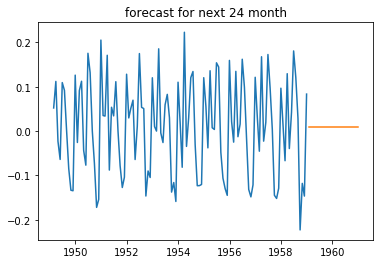

In [16]:
plt.plot(airpassengers_diff_train)
plt.plot(ses_forecast)
plt.title('forecast for next 24 month')

Inverse differencing

In [17]:
ses_forecast[0] = ses_forecast[0] + airpassengers_log_train[-1]
ses_forecast_inv_diff = ses_forecast.cumsum()

Inverse log transformation

In [18]:
ses_forecast_inv_log = np.exp(ses_forecast_inv_diff)

Text(0.5, 1.0, 'inverse log transformation')

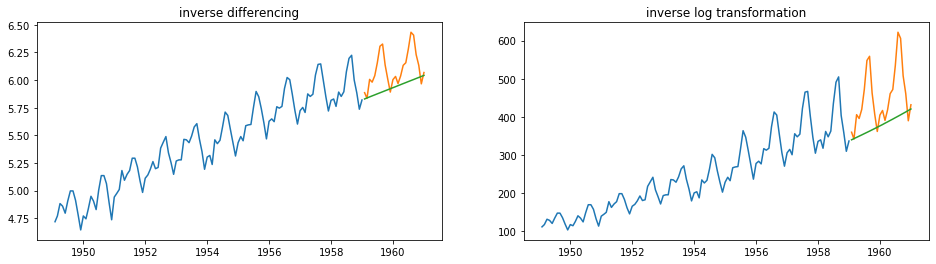

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_log_train)
ax1.plot(airpassengers_log_test)
ax1.plot(ses_forecast_inv_diff)
ax1.set_title('inverse differencing')

ax2.plot(airpassengers_train)
ax2.plot(airpassengers_test)
ax2.plot(ses_forecast_inv_log)
ax2.set_title('inverse log transformation')

# References

1. https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
2. https://machinelearningmastery.com/time-series-data-stationary-python/
3. http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/
4. https://rstudio-pubs-static.s3.amazonaws.com/223827_937f502e3e89492a95404356034ea1a7.html
5. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
6. https://www.reddit.com/r/AskStatistics/comments/5ydt2c/if_my_aic_and_bic_are_negative_does_that_mean/